# Crea un supresor de ruido de imágenes con el MNIST

In [25]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA

## 1. Cargar los datos normalizados y como tensores.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## 2. Creación de la arquitectura del autoencoder.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 64, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # -> N, 64, 1, 1
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, output_padding=0), # -> 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, output_padding=0), # -> 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## 3. Entrenamiento.

### 3.1. Función que añade ruido gaussiano.

In [4]:
def add_noise(imgs):
    noise = torch.randn_like(imgs) * 0.2
    noisy_imgs = imgs + noise
    return noisy_imgs

### 3.2. Configuración del dispositivo y modelo.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

### 3.3. Entrenamiento.

In [7]:
num_epochs = 10

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0
    for batch_data in data_loader:
        inputs = batch_data[0].to(device)
        noisy_inputs = add_noise(inputs)

        optimizer.zero_grad()
        outputs = autoencoder(noisy_inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    average_loss = running_loss / len(data_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}")

Epoch [1/10] - Loss: 0.0295
Epoch [2/10] - Loss: 0.0077
Epoch [3/10] - Loss: 0.0063
Epoch [4/10] - Loss: 0.0057
Epoch [5/10] - Loss: 0.0054
Epoch [6/10] - Loss: 0.0053
Epoch [7/10] - Loss: 0.0051
Epoch [8/10] - Loss: 0.0050
Epoch [9/10] - Loss: 0.0050
Epoch [10/10] - Loss: 0.0049


## 4. Guardar el modelo.

In [8]:
torch.save(autoencoder, './modelos/autoencoder_ruido.pth')

## 5. Visualización de un ejemplo.

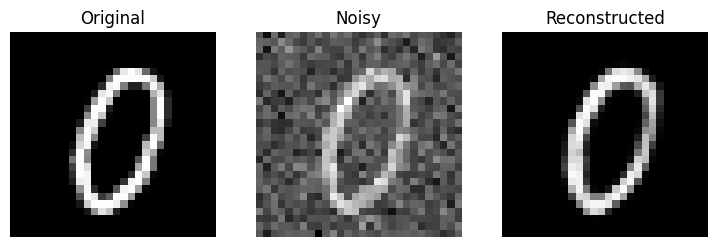

In [9]:
autoencoder.to(device)
autoencoder.eval()

test_images, _ = next(iter(data_loader_valid))
test_image = test_images[0].unsqueeze(0).to(device)  
noisy_test_image = add_noise(test_image)

with torch.no_grad():
    reconstructed_image = autoencoder(noisy_test_image)

test_image_np = test_image.cpu().squeeze().numpy()
noisy_test_image_np = noisy_test_image.cpu().squeeze().numpy()
reconstructed_image_np = reconstructed_image.cpu().squeeze().numpy()

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.imshow(test_image_np, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_test_image_np, cmap='gray')
plt.title('Noisy')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image_np, cmap='gray')
plt.title('Reconstructed')
plt.axis('off')

plt.show()

## 6. Medidas del rendimiento del modelo.

### 6.1. PSNR (Peak Signal-to-Noise Ratio). 
Medir la calidad de una imagen comprimida o restaurada en comparación con la imagen original.

$PSNR = 10 \cdot \log_{10}\left(\frac{MSE}{M^2}\right)$

Donde:
- MSE (Mean Squared Error): El error cuadrático medio que representa la diferencia promedio al cuadrado entre los valores de los píxeles de la imagen original y la imagen reconstruida o procesada. 
- $M^2$: M representa el valor máximo que puede tener un píxel en la imagen. Usualmente, en imágenes de 8 bits, M es igual a 255. Elevar M al cuadrado (M^2) se utiliza en la métrica para normalizar el MSE y escalarlo en función del rango dinámico de los valores de píxeles en la imagen. Esta normalización es necesaria para que el PSNR tenga sentido en decibelios.

In [11]:
autoencoder.eval()

psnr_values = []
for val_data in data_loader_valid:
    inputs = val_data[0].to(device)
    noisy_inputs = add_noise(inputs)
    
    with torch.no_grad():
        outputs = autoencoder(noisy_inputs)
    
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()
    
    mse = mean_squared_error(inputs.flatten(), outputs.flatten())
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    
    psnr_values.append(psnr)

average_psnr = np.mean(psnr_values)

print(f"PSNR promedio: {average_psnr:.2f} dB")

PSNR promedio: 71.29 dB


Un PSNR promedio de 71.29 dB indica que las imágenes reconstruidas por tu modelo Autoencoder son muy similares a las imágenes originales, ya que la relación entre la señal (la imagen original) y el ruido (la diferencia entre la imagen original y la imagen reconstruida) es alta.

## 6.2. SSIM (Structural Similarity Index Measure).
Esta métrica se enfoca en medir la similitud estructural entre dos imágenes. Es útil para capturar cambios en textura y estructura, no solo en intensidad de píxeles.

$SSIM(x, y) = \frac{{(2 \cdot \mu_x \cdot \mu_y + C_1) \cdot (2 \cdot \sigma_{xy} + C_2)}}{{(\mu_x^2 + \mu_y^2 + C_1) \cdot (\sigma_x^2 + \sigma_y^2 + C_2)}}$

Donde:
- $x$ e $y$ son las dos imágenes que se están comparando.
- $\mu_x$ y $\mu_y$ son las medias locales de las imágenes $x$ e $y$ respectivamente.
- $\sigma_x$ y $\sigma_y$ son las desviaciones estándar locales de las imágenes $x$ e $y$ respectivamente.
- $\sigma_{xy}$ es la covarianza local entre $x$ e $y$.
- $C_1$ y $C_2$ son constantes pequeñas que se utilizan para evitar la indeterminación cuando las variables en el denominador son muy pequeñas.

In [17]:
autoencoder.eval()

ssim_scores = []

with torch.no_grad():
    for batch_data in data_loader_valid:
        inputs = batch_data[0].to(device)
        noisy_inputs = add_noise(inputs)

        reconstructed_outputs = autoencoder(noisy_inputs)
        inputs = inputs.cpu().numpy()
        reconstructed_outputs = reconstructed_outputs.cpu().numpy()

        for i in range(inputs.shape[0]):
            ssim_score = ssim(inputs[i, 0], reconstructed_outputs[i, 0], data_range=1)
            ssim_scores.append(ssim_score)

average_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"SSIM promedio: {average_ssim:.4f}")

SSIM promedio: 0.9413


El valor del SSIM varía entre -1 y 1, donde 1 indica una similitud perfecta entre las imágenes, 0 indica que las imágenes son completamente diferentes y -1 indica una similitud perfecta pero con una inversión de los valores de píxeles. Por lo tanto, un valor de 0.9413 está bastante cerca del valor máximo de 1, lo que sugiere una alta similitud estructural entre las imágenes originales y las imágenes reconstruidas.

## 6.3. MAE (Mean Absolute Error).

A diferencia de MSE, MAE proporciona un error medio absoluto entre la imagen reconstruida y la original, lo que puede ser más interpretable en ciertos contextos.

$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

Donde:
- $n$ es el número total de observaciones o muestras.
- $y_i$ son las imágenes reales.
- $\hat{y_i}$ son las imágenes predichas por el modelo.

In [19]:
mae_scores = []

with torch.no_grad():
    for batch_data in data_loader_valid:
        inputs = batch_data[0].to(device)
        noisy_inputs = add_noise(inputs)

        reconstructed_outputs = autoencoder(noisy_inputs)

        mae = F.l1_loss(reconstructed_outputs, inputs, reduction='mean').item()
        mae_scores.append(mae)

average_mae = sum(mae_scores) / len(mae_scores)
print(f"MAE promedio: {average_mae:.4f}")

MAE promedio: 0.0222


Un MAE de 0.0222 es muy bajo, lo que sugiere que tu modelo tiene un rendimiento excelente en la tarea de predicción. Significa que, en promedio, las predicciones del modelo difieren en solo 0.0222 unidades (en la misma escala que los valores reales) de los valores reales en el conjunto de datos de validación.

## 6.4. Histogramas de Intensidades.

Comparar los histogramas de intensidades de píxeles entre las imágenes originales y las reconstruidas puede ofrecer una visión cualitativa de cómo el autoencoder está manejando las diferentes intensidades en la imagen. Por tanto, se ha escogido una imagen aleatoria para mostrar su histograma de densidad.

In [23]:
autoencoder.eval()

random_index = np.random.randint(len(data_loader_valid))
for i, batch_data in enumerate(data_loader_valid):
    if i == random_index:
        sample_data = batch_data[0].to(device)
        noisy_sample_data = add_noise(sample_data)
        break

with torch.no_grad():
    reconstructed_sample = autoencoder(noisy_sample_data)

sample_data = sample_data.cpu().numpy()
reconstructed_sample = reconstructed_sample.cpu().numpy()

original_histogram = np.histogram(sample_data[0, 0], bins=256, range=(0, 1))
reconstructed_histogram = np.histogram(reconstructed_sample[0, 0], bins=256, range=(0, 1))

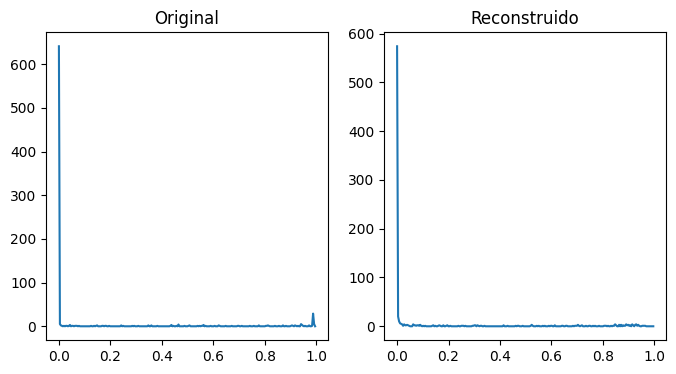

In [24]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Original")
plt.plot(original_histogram[1][:-1], original_histogram[0])

plt.subplot(122)
plt.title("Reconstruido")
plt.plot(reconstructed_histogram[1][:-1], reconstructed_histogram[0])

plt.show()

La semejanza en la forma general de ambos histogramas sugiere que el autoencoder ha sido bastante efectivo en la reconstrucción de los datos originales desde la versión ruidosa. El pico muy alto cerca de cero en ambos histogramas indica que la mayoría de los valores son muy bajos, y la reconstrucción parece haber preservado esa característica.

## 6.5. Representar el espacio latente con PCA.

In [46]:
def get_latent_representations(data_loader, model, device):
    model.eval()
    latent_representations = []
    labels = []

    with torch.no_grad():
        for batch_data in data_loader:
            inputs = batch_data[0].to(device)
            noisy_inputs = add_noise(inputs)
            encoded = model.encoder(noisy_inputs)
            latent_representations.append(encoded.cpu().numpy())
            labels.append(batch_data[1].cpu().numpy())

    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return latent_representations, labels 

In [51]:
latent_representations, labels = get_latent_representations(data_loader_valid, autoencoder, device)
latent_representations_flat = latent_representations.reshape(-1, 64)

(10000, 64)
(10000,)
(10000, 64, 1, 1)


In [48]:
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations_flat)

pca_3d = PCA(n_components=3)
latent_3d = pca_3d.fit_transform(latent_representations_flat)

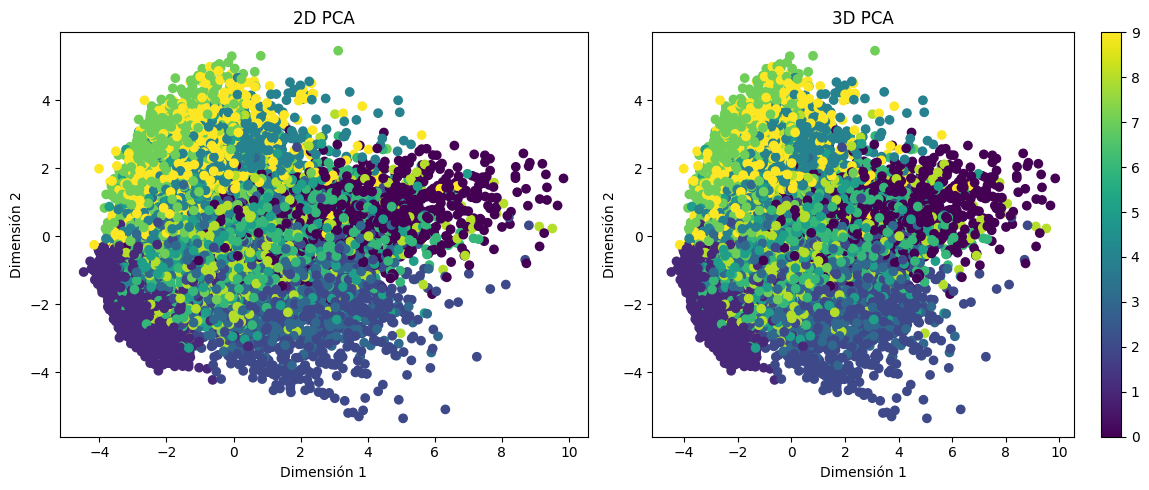

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels)
axes[0].set_title('2D PCA')
axes[0].set_xlabel('Dimensión 1')
axes[0].set_ylabel('Dimensión 2')

scatter = axes[1].scatter(latent_3d[:, 0], latent_3d[:, 1], c=labels)
axes[1].set_title('3D PCA')
axes[1].set_xlabel('Dimensión 1')
axes[1].set_ylabel('Dimensión 2')
fig.colorbar(scatter)

plt.tight_layout()
plt.show()

En ambas representaciones, 2D y 3D PCA, los colores corresponden a los dígitos manuscritos (del 0 al 9) del conjunto MNIST proyectados en el espacio latente. Dada la presencia de ruido en las imágenes originales, es esperable una cierta superposición y mezcla de colores en las representaciones PCA, reflejando la variabilidad y similitud entre diferentes números cuando son afectados por distorsiones.

No obstante, la presencia de agrupaciones distinguibles de colores sugiere que, a pesar de la influencia del ruido, el autoencoder ha logrado extraer y preservar características esenciales de los números. Estas características permiten diferenciar efectivamente entre los diferentes dígitos en el espacio latente, lo cual se manifiesta en la formación de zonas donde predominan colores específicos correspondientes a distintos números. Esto demuestra que el autoencoder es capaz de reducir el ruido y de capturar la esen